In [25]:
!pip install pandas numpy matplotlib seaborn nltk wordcloud scikit-learn imbalanced-learn gradio


In [26]:
# Import the required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Tokenizer models
nltk.download('wordnet')  # Lemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek  # For handling imbalance
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [27]:
tweet_df = pd.read_csv('/content/train.csv')

In [45]:
tweet_df.head()

,id,label,tweet
0,1,0,father dysfunctional selfish drag kid dysfunct...
1,2,0,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday majesty
3,4,0,model love u take u time urð ðððð ððð
4,5,0,factsguide society motivation


In [46]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29530 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29530 non-null  int64 
 1   label   29530 non-null  int64 
 2   tweet   29530 non-null  object
dtypes: int64(2), object(1)
memory usage: 922.8+ KB


In [28]:
tweet_df = tweet_df.drop_duplicates('tweet')

In [29]:
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if w not in stopwords.words('english')]
    return " ".join(filtered_tweets)

tweet_df['tweet'] = tweet_df['tweet'].apply(data_processing)

In [30]:
lemmatizer = WordNetLemmatizer()
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [31]:
print("Class distribution before balancing:")
print(tweet_df['label'].value_counts())

Class distribution before balancing:
label
0    27517
1     2013
Name: count, dtype: int64


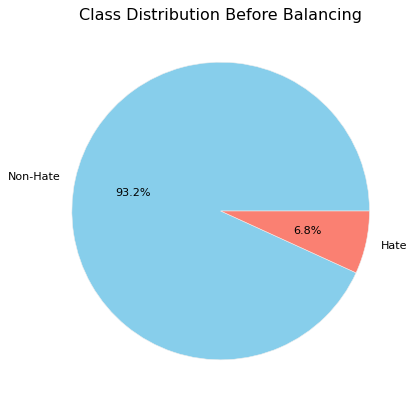

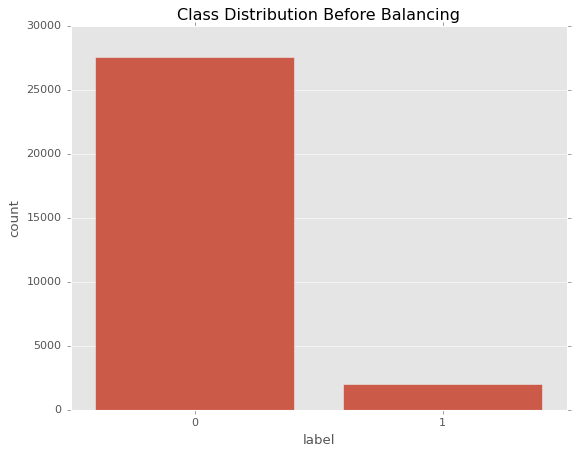

In [32]:
plt.figure(figsize=(6, 6))
tweet_df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=["Non-Hate", "Hate"], colors=["skyblue", "salmon"])
plt.title("Class Distribution Before Balancing")
plt.ylabel("")
plt.show()

sns.countplot(x='label', data=tweet_df)
plt.title('Class Distribution Before Balancing')
plt.show()

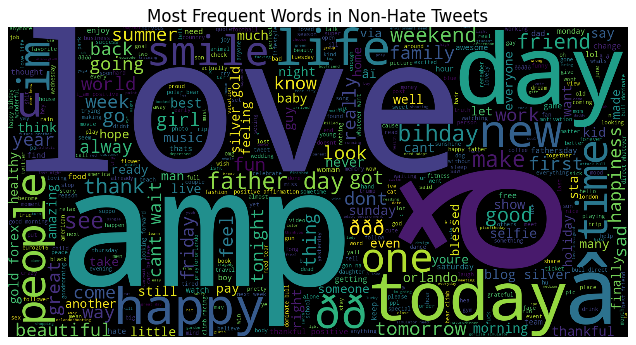

In [33]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
text = ' '.join(non_hate_tweets['tweet'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Hate Tweets', fontsize=15)
plt.show()

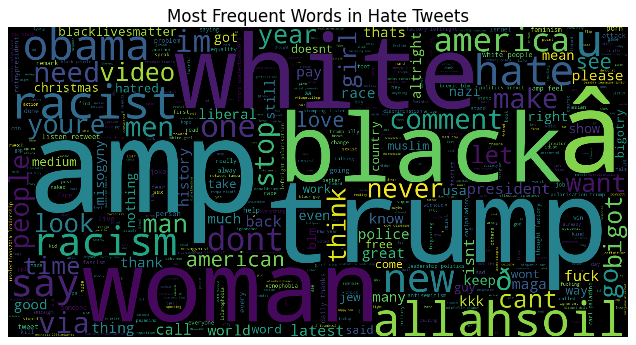

In [34]:
hate_tweets = tweet_df[tweet_df.label == 1]
text = ' '.join(hate_tweets['tweet'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Hate Tweets', fontsize=15)
plt.show()

In [35]:
vect = TfidfVectorizer(ngram_range=(1, 3)).fit(tweet_df['tweet'])
X = vect.transform(tweet_df['tweet'])
Y = tweet_df['label']


In [36]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled, Y_resampled = smote_tomek.fit_resample(X, Y)

In [37]:
unique, counts = np.unique(Y_resampled, return_counts=True)
print(f"Class distribution after SMOTETomek: {dict(zip(unique, counts))}")

Class distribution after SMOTETomek: {0: 27517, 1: 27517}


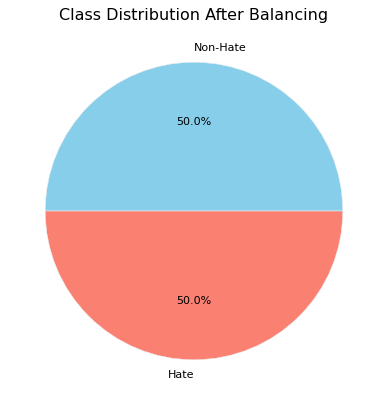

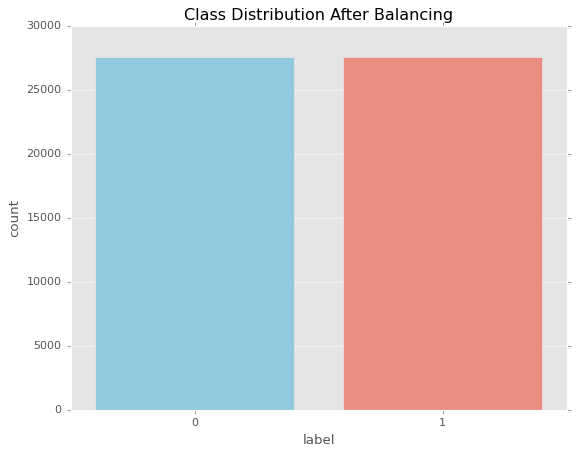

In [38]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=["Non-Hate", "Hate"], autopct='%1.1f%%', colors=["skyblue", "salmon"])
plt.title("Class Distribution After Balancing")
plt.show()

sns.countplot(x=Y_resampled, palette=["skyblue", "salmon"])
plt.title('Class Distribution After Balancing')
plt.show()

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)


In [40]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)


LogisticRegression(max_iter=1000)

In [41]:
y_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {logreg_acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 96.37%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      5481
           1       0.97      0.96      0.96      5526

    accuracy                           0.96     11007
   macro avg       0.96      0.96      0.96     11007
weighted avg       0.96      0.96      0.96     11007



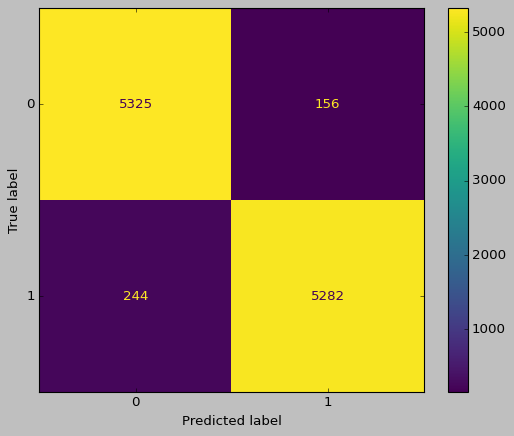

In [42]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [43]:
import pickle
with open('hate_speech_model.pkl', 'wb') as model_file:
    pickle.dump(logreg, model_file)
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vect, vectorizer_file)

print("Model and vectorizer saved!")


Model and vectorizer saved!


In [44]:
import gradio as gr

def predict_hate_speech(tweet):
    # Load the model and vectorizer
    with open('hate_speech_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    with open('vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)

    # Preprocess the input tweet
    tweet = data_processing(tweet)
    tweet_vect = vectorizer.transform([tweet])

    # Make a prediction
    prediction = model.predict(tweet_vect)
    return "Hate Speech" if prediction == 1 else "Non-Hate Speech"

iface = gr.Interface(
    fn=predict_hate_speech,
    inputs=gr.Textbox(lines=3, placeholder="Type your tweet here...", label="Enter Tweet"),
    outputs=gr.Textbox(label="Prediction"),
    title="Hate Speech Detection",
    description="Detect whether a tweet contains hate speech. Enter a tweet and see the result!",
    examples=[
        ["I love the world!"],
        ["I hate you!"],
        ["You are amazing!"]
    ],
    theme="default",
    live=False
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4c544701092cb7be26.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
